In [ ]:
# import os
# # import Google Drive 套件
# from google.colab import drive
# # 將自己的雲端硬碟掛載上去
# drive.mount('/content/gdrive')

# os.chdir('./gdrive/MyDrive/Colab Notebooks/deep_learning/hw4')      # 檔案目錄

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# os.listdir('./../../../../../'), os.getcwd()

(['.config', 'images', 'gdrive', 'sample_data'],
 '/content/gdrive/My Drive/Colab Notebooks/deep_learning/hw4')

In [ ]:
# import shutil
# shutil.copyfile('./images.zip', './../../../../../images.zip')

'./../../../../../images.zip'

In [ ]:
# import zipfile
# def zip_list(file_path):
#     zf = zipfile.ZipFile(file_path, 'r')
#     zf.extractall('./../../../../../')

# file_path = './../../../../../images.zip'
# zip_list(file_path)

In [ ]:
# os.remove('./../../../../../images.zip')

In [1]:
import numpy as np
import cv2
import torch
import torch.nn as nn
import functions as fc
import LeNet_module as mc
import importlib
import pandas as pd
import random
import pickle
import time
import matplotlib.pyplot as plt

In [2]:
!nvidia-smi

Mon May 03 16:26:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 442.23       Driver Version: 442.23       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 165... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   52C    P8     2W /  N/A |    134MiB /  4096MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Load image path

In [8]:
train_df = pd.read_csv('./images/train.txt', sep=' ', header=None)
test_df = pd.read_csv('./images/test.txt', sep=' ', header=None)
val_df = pd.read_csv('./images/val.txt', sep=' ', header=None)
train_paths, train_response = './images/' + train_df[0].to_numpy(), train_df[1].to_numpy()
test_paths, test_response = './images/' + test_df[0].to_numpy(), test_df[1].to_numpy()
val_paths, val_response = './images/' + val_df[0].to_numpy(), val_df[1].to_numpy()
train_paths.shape, test_paths.shape, val_paths.shape

((63325,), (450,), (450,))

In [ ]:
# train_paths = train_paths[0:10]

In [ ]:
# train_df = pd.read_csv('./images/train.txt', sep=' ', header=None)
# test_df = pd.read_csv('./images/test.txt', sep=' ', header=None)
# val_df = pd.read_csv('./images/val.txt', sep=' ', header=None)
# train_paths, train_response = './../../../../../images/' + train_df[0].to_numpy(), train_df[1].to_numpy()
# test_paths, test_response = './../../../../../images/' + test_df[0].to_numpy(), test_df[1].to_numpy()
# val_paths, val_response = './../../../../../images/' + val_df[0].to_numpy(), val_df[1].to_numpy()
# train_paths.shape, test_paths.shape, val_paths.shape

((63325,), (450,), (450,))

# module define  pytorch

In [75]:
importlib.reload(mc)
importlib.reload(fc)

<module 'functions' from 'D:\\study\\成大\\soa2\\deep_learning\\hw4\\functions.py'>

In [76]:
epochs = 200
batchs = 200
lr = 0.01

In [77]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [78]:
module = mc.LeNet_module().to(device)
lossf = nn.CrossEntropyLoss().to(device)
opt = torch.optim.Adam(module.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
len(list(module.parameters()))

14

In [79]:
inputs = fc.path2pic(train_paths[0:10])
inputs = torch.tensor(inputs, dtype=torch.float).to(device)
outputs = module(inputs)

In [80]:
outputs.shape

torch.Size([10, 50])

In [ ]:
logger = fc.create_logger('./logger/', 'logger.txt')

In [ ]:
# logger.handlers

In [ ]:
# logger.disabled = True  #暫停 logger
# for i in logger.handlers:
#     logger.removeHandler(i)
# logger.handlers = []
# del(logger)

In [ ]:
train_accu1 = []
val_accu1 = []
train_accu5 = []
val_accu5 = []

# train

In [ ]:
N = train_paths.shape[0]
trainIndex = [i for i in range(N)]
random.shuffle(trainIndex)

In [ ]:
# np.random.choice(train_paths, replace=False, size=5)

In [ ]:
module_save_path = './model/module.pt'
accu_save_path = './model/accu.pickle'

start = time.time()
logger.info('start at {}'.format(start))

for epoch in range(1, epochs+1):
    logger.info('-' * 10)
    logger.info('Epoch {}/{}'.format(epoch, epochs))
    
    for phase in ['train', 'val']:
        if phase == 'train':
            c = 0
            while c < N:
                Index = trainIndex[c:c+batchs]
                imgList = train_paths[Index]
                inputs = fc.path2pic(imgList)
                inputs = torch.tensor(inputs, dtype=torch.float).to(device)
                real = train_response[Index]
                real = torch.tensor(real, dtype=torch.long).to(device)
                outputs = module(inputs)
                loss = lossf(outputs, real)
                logger.info('loss: {}'.format(loss.item()))
                loss.backward()
                opt.step()
                c += batchs
            
            inputs = fc.path2pic(np.random.choice(train_paths, replace=False, size=200))
            inputs = torch.tensor(inputs, dtype=torch.float).to(device)
            with torch.no_grad():
                outputs = module(inputs).cpu().clone().detach()
            
            accu1 = fc.top_n_accuracy(outputs, train_response, n=1)
            accu5 = fc.top_n_accuracy(outputs, train_response, n=5)
            train_accu1.append(accu1)
            train_accu5.append(accu5)
            
        else:
            inputs = fc.path2pic(val_paths)
            inputs = torch.tensor(inputs, dtype=torch.float).to(device)
            with torch.no_grad():
                outputs = module(inputs).cpu().clone().detach()
            accu1 = fc.top_n_accuracy(outputs, val_response, n=1)
            accu5 = fc.top_n_accuracy(outputs, val_response, n=5)
            val_accu1.append(accu1)
            val_accu5.append(accu5)
        
        accu_dict = {'train1':train_accu1, 'val1':val_accu1, 'train5':train_accu5, 'val5':val_accu5}
    with open(accu_save_path, 'wb') as f:
        pickle.dump(accu_dict, f)

    train_time = time.time() - start
    torch.save(module.state_dict(), module_save_path)
    logger.info('train time {}, {}/{}'.format(train_time, epoch, epochs))

2021-04-29 07:08:22,523 INFO start at 1619680102.5239038
2021-04-29 07:08:22,526 INFO Epoch 1/200
2021-04-29 07:08:22,530 INFO ----------
2021-04-29 07:08:24,282 INFO loss: 3.9122040271759033
2021-04-29 07:08:26,286 INFO loss: 3.9258110523223877
2021-04-29 07:08:28,192 INFO loss: 3.9358110427856445
2021-04-29 07:08:30,103 INFO loss: 3.920811176300049
2021-04-29 07:08:32,016 INFO loss: 3.9258110523223877
2021-04-29 07:08:33,928 INFO loss: 3.9308111667633057
2021-04-29 07:08:35,841 INFO loss: 3.9308111667633057
2021-04-29 07:08:37,757 INFO loss: 3.915811061859131
2021-04-29 07:08:39,664 INFO loss: 3.920811176300049
2021-04-29 07:08:41,575 INFO loss: 3.9358110427856445
2021-04-29 07:08:43,479 INFO loss: 3.920811176300049
2021-04-29 07:08:45,394 INFO loss: 3.9308111667633057
2021-04-29 07:08:47,296 INFO loss: 3.915811061859131
2021-04-29 07:08:49,209 INFO loss: 3.9408111572265625
2021-04-29 07:08:51,116 INFO loss: 3.920811176300049
2021-04-29 07:08:53,042 INFO loss: 3.9258110523223877
2021

# test

In [3]:
module_save_path = './model/torch/module.pt'
accu_save_path = './model/torch/accu.pickle'

In [4]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
module = mc.LeNet_module().to(device)

In [5]:
module.load_state_dict(torch.load(module_save_path))

<All keys matched successfully>

In [6]:
test_df = pd.read_csv('./images/test.txt', sep=' ', header=None)
test_response = test_df[1].to_numpy()

with open(accu_save_path, 'rb') as f:
    accu_dict = pickle.load(f)

In [9]:
test_paths.shape

(450,)

In [10]:
inputs.shape

NameError: name 'inputs' is not defined

In [11]:
inputs = fc.path2pic(test_paths)
inputs = torch.tensor(inputs, dtype=torch.float).to(device)
Ypred = module(inputs).cpu().detach().numpy()

In [12]:
# top 1 accuracy                      top 5 accuracy
fc.top_n_accuracy(Ypred, test_response, n=1), fc.top_n_accuracy(Ypred, test_response, n=5)

(0.02, 0.1)

# draw curve

In [13]:
train_accu1 = accu_dict['train1']
val_accu1 = accu_dict['val1']
train_accu5 = accu_dict['train5']
val_accu5 = accu_dict['val5']

In [14]:
val_accu1[-1], val_accu5[-1]

(0.02, 0.1)

In [15]:
X = [i for i in range(len(train_accu1))]

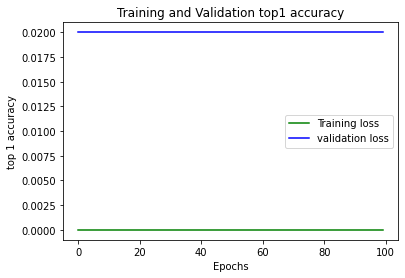

In [16]:
plt.plot(X, train_accu1, 'g', label='Training loss')
plt.plot(X, val_accu1, 'b', label='validation loss')
plt.title('Training and Validation top1 accuracy')
plt.xlabel('Epochs')
plt.ylabel('top 1 accuracy')
plt.legend()
plt.savefig('top1 accuracy.png')
plt.show()

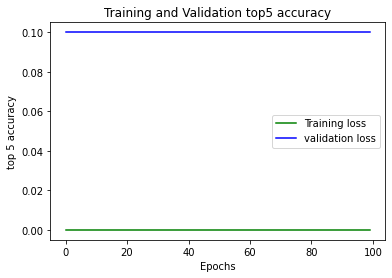

In [17]:
plt.plot(X, train_accu5, 'g', label='Training loss')
plt.plot(X, val_accu5, 'b', label='validation loss')
plt.title('Training and Validation top5 accuracy')
plt.xlabel('Epochs')
plt.ylabel('top 5 accuracy')
plt.legend()
plt.savefig('top5 accuracy.png')
plt.show()

# try

In [ ]:
x = np.ones([4, 5])
np.matmul(np.ones(4), x)

In [ ]:
x = np.ones([5, 5])
y = np.array([1, 2, 3, 4, 5]).T
x.T * y, y * x

In [ ]:
y

In [ ]:
class Perceptron:
    def __init__(self, n_inputs, activ_func='Sign', save_fig=False):
        self.weights = np.array([0.0] * (n_inputs + 1)) # 1 more for bias
        self.__save_fig = save_fig
        #self.__activation = ActivationFunction(activ_func)
        
    @property
    def weight(self):
        return self.weights[:]

In [ ]:
p = Perceptron(5)

In [ ]:
p.weight

In [ ]:
x = np.random.rand(5, 5)
x

In [ ]:
x + np.ones([1, 5])

In [ ]:
np.ones([1, 5])

In [ ]:
np.argsort(np.random.rand(4, 5), axis=1)

In [ ]:
5 in np.array([3, 5])

In [ ]:
x = np.random.rand(4, 5)
x

In [ ]:
y = np.array([2, 3, 4, 5]).reshape([1, -1])
x / y.T

In [ ]:
np.sum(x, axis=1)

In [ ]:
y